# TP 1 - Tópicos de Minería de Datos
### Juan Ignacio Farizano

--------------------------------------------------------------------------------

In [33]:
# Imports iniciales
library(data.table)
library(ggplot2)
library(caret)
library(party)
library(class)

--------------------------------------------------------------------------------
## Ejercicio 1

In [2]:
calcularError <- function(true, predicted) {
  x <- predicted != true$Class
  length(x[x == TRUE]) / length(true$Class)
}

In [3]:
# Punto a
generatePoints <- function(d, n, std, center0, center1) {
  lenClass1 <- floor(n / 2)
  lenClass0 <- n - lenClass1

  class0 <- replicate(n = lenClass0, as.list(c(rnorm(d, mean = center0, sd = std), 0)), simplify = FALSE)
  class1 <- replicate(n = lenClass1, as.list(c(rnorm(d, mean = center1, sd = std), 1)), simplify = FALSE)
  data <- c(class0, class1)

  df <- rbindlist(data)
  colnames(df) <- c(1:d, "Class")
  df <- as.data.frame(df)
  df$Class <- as.factor(df$Class)
  df
}

generateDiagonal <- function(d, n, C) {
  generatePoints(d, n, C * sqrt(d), rep(-1, d), rep(1, d))
}

In [4]:
# Punto b
cartesianToPolar <- function(x, y){
  ro = sqrt(x ** 2 + y ** 2)

  if (x > 0 && y >= 0) {
    theta = atan(y / x)
  } else if (x == 0 && y > 0) {
    theta = pi / 2
  } else if (x < 0) {
    theta = atan(y / x) + pi
  } else if (x == 0 && y < 0) {
    theta = (3 * pi) / 2
  } else if (x > 0 && y < 0) {
    theta = atan(y / x) + 2 * pi
  }

  c(ro, theta)
}

# Básicamente robé mi código de IAA y lo adapté a R
generateSpirals <- function(n) {
  radius = 1
  centerX <- 0
  centerY <- 0

  # Si n es impar la clase 0 va a tener un elemento más que la clase 1
  lenClass1 <- floor(n / 2)
  lenClass0 <- n - lenClass1

  # Ints para iterar sobre la cantidad actual de puntos generados para cada clase
  cantClass0 = 0
  cantClass1 = 0

  data <- data.frame()

  # No sé si habrá una forma vectorial más fácil de hacer esto
  # spoilers: no la hay según Pablo
  # ¿faltan comentarios? sí, pero no tengo ganas de comentar todo de nuevo
  while (cantClass0 < lenClass0 || cantClass1 < lenClass1) {
    y <- runif(1, min = -1, max = 1)
    x <- runif(1, min = -1, max = 1)

    polarCoords <- cartesianToPolar(x, y)
    ro <- polarCoords[1]
    theta <- polarCoords[2]


    if (ro <= 1) {
      betweenCurves <- FALSE

      for (theta0 in (theta + (2 * pi * -1:6))) {
        if ((theta0 / (4 * pi)) <= ro && ro <= ((theta0 + pi) / (4 * pi))) {
          if (cantClass0 < lenClass0) {
            data <- rbind(data, c(x, y, 0))
            cantClass0 <- cantClass0 + 1
          }
          betweenCurves <- TRUE
          next
        }
      }

      if (cantClass1 < lenClass1 && !betweenCurves) {
        data <- rbind(data, c(x, y, 1))
        cantClass1 <- cantClass1 + 1
      }
    }
  }

  df <- as.data.frame(data)
  colnames(df) <- c(1, 2, "Class")
  df$Class <- as.factor(df$Class)
  df
}

--------------------------------------------------------------------------------
## Ejercicio 2

In [5]:
graphDF <- function(df, title="") {
    ggplot(df, aes(x=df[,1], y=df[,2], color=Class)) + 
           geom_point() +
           labs(title=title, color="Clase", x="", y="")
}


   0    1 
1000 1000 

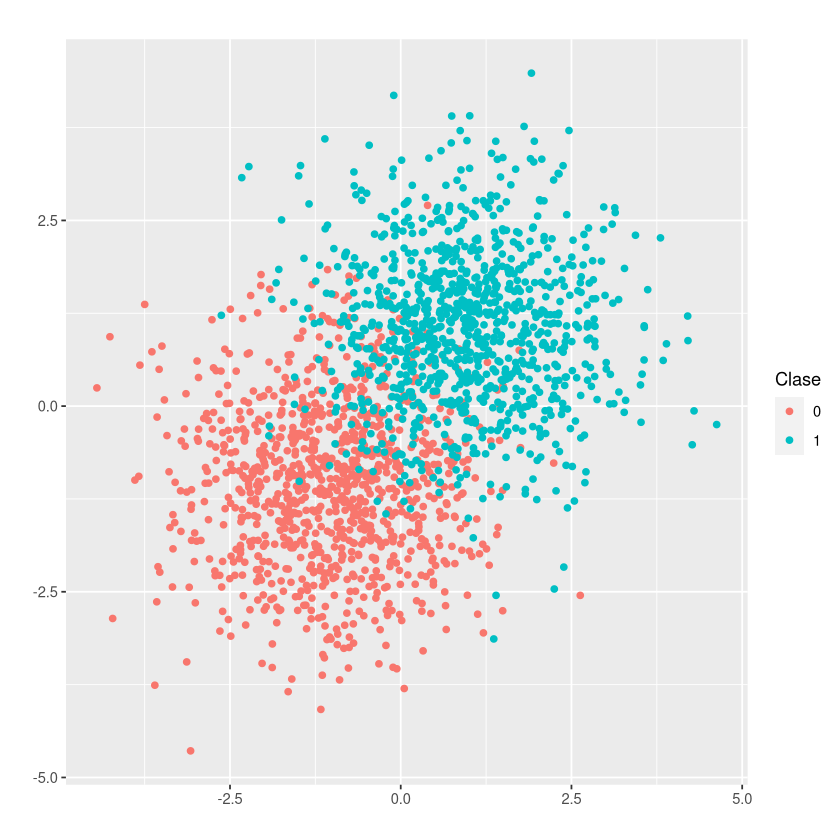

In [11]:
df <- generateDiagonal(2, 2000, 0.78)
# Chequeo la cantidad de cada clase
table(df[, "Class"])
graphDF(df)


   0    1 
2500 2500 

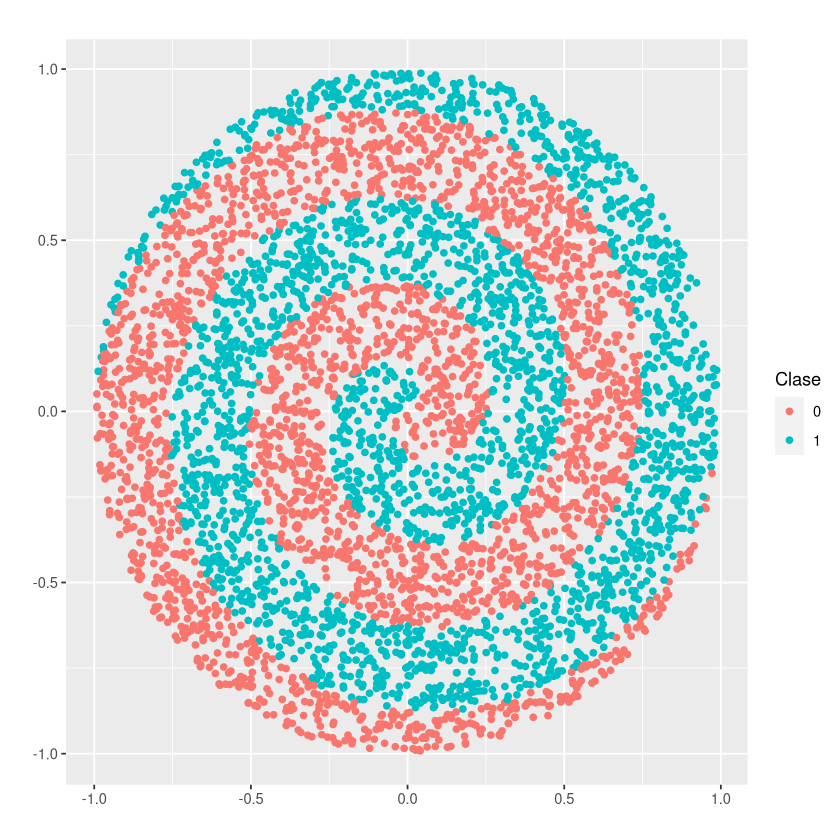

In [7]:
df <- generateSpirals(5000)
# Chequeo la cantidad de cada clase
table(df[, "Class"])
graphDF(df)

--------------------------------------------------------------------------------
## Ejercicio 3

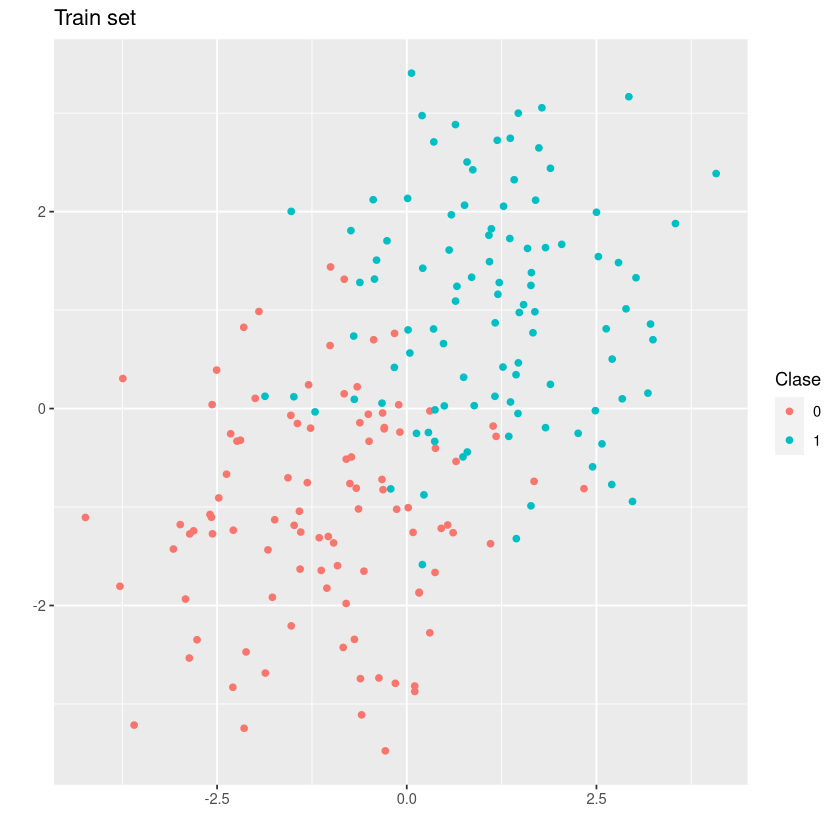

   predictTreeDiagonal
      0   1
  0 888 112
  1 148 852

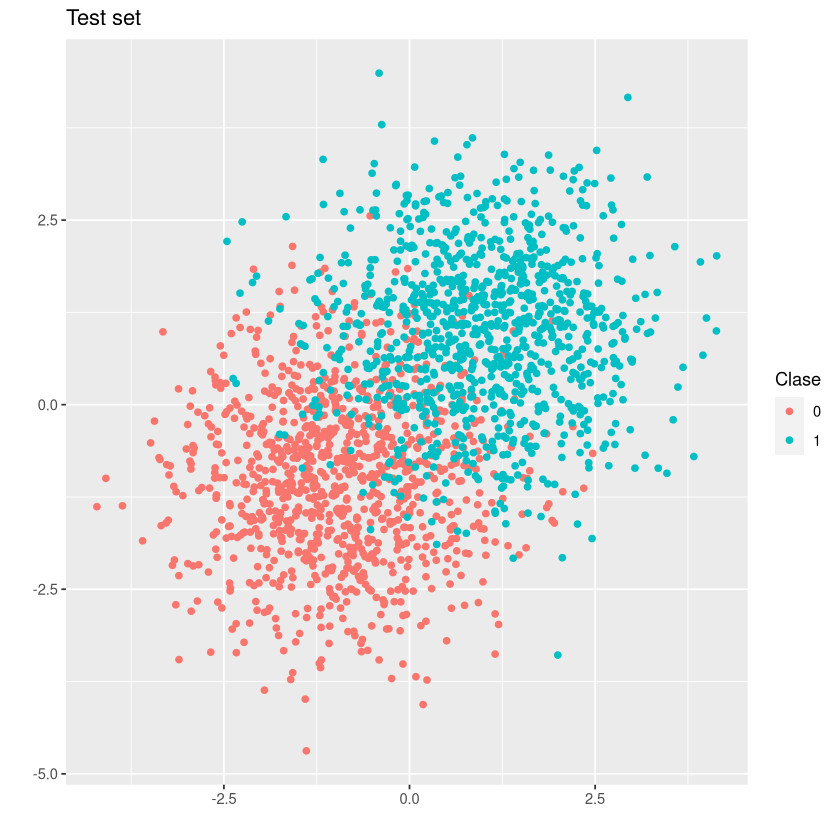

   predictKNNDiagonal
      0   1
  0 992   8
  1   5 995

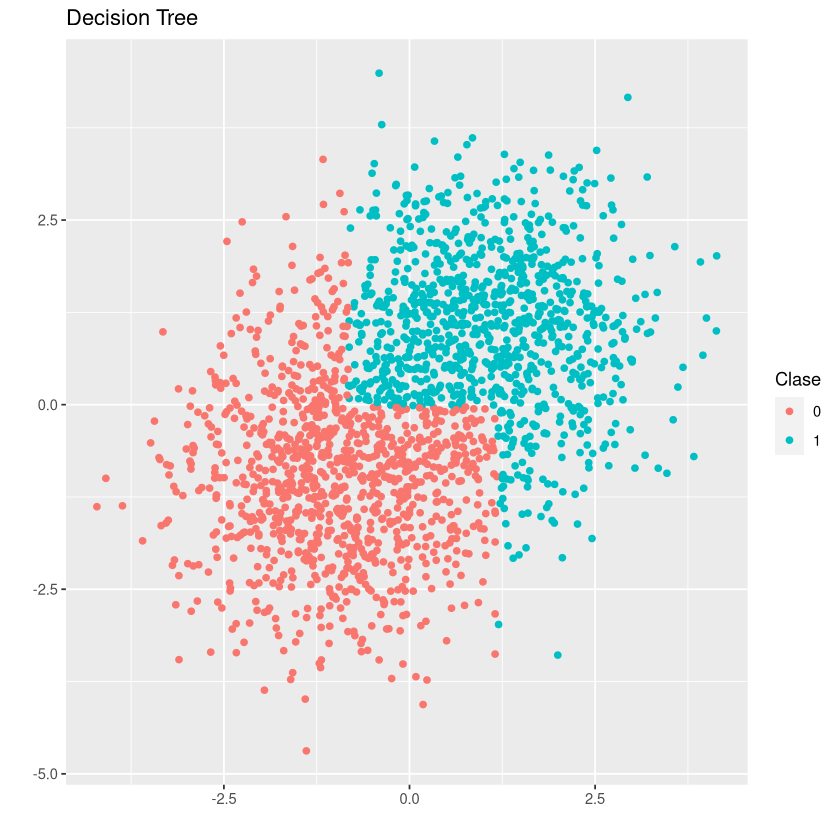

Errores finales 
Sin folds
Error de árbol:  0.13 
Error de KNN:  0.0065 
Con folds
Error de árbol:  0.17 
Error de KNN:  0.015 


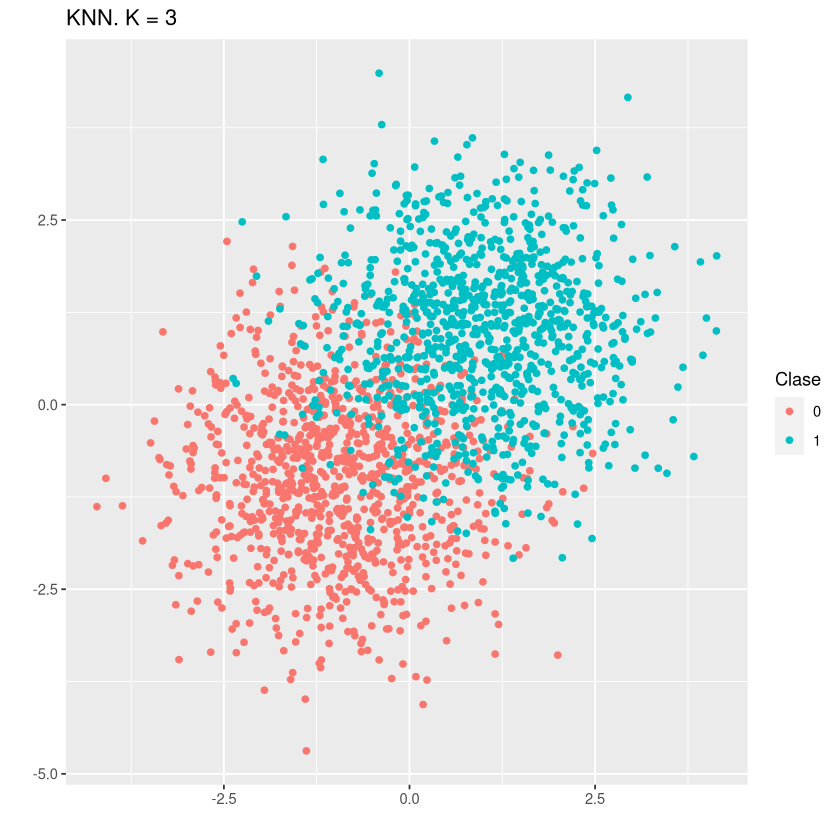

In [30]:
# Los outputs salen totalmente fuera de orden, cosa de jupyter ¯\_(ツ)_/¯
# Genero los conjuntos de entrenamiento y test
dfTrainDiagonal = generateDiagonal(2, 200, 0.78)
dfTestDiagonal = generateDiagonal(2, 2000, 0.78)

# Los grafico
graphDF(dfTrainDiagonal, title = "Train set")
graphDF(dfTestDiagonal, title = "Test set")

# Creo un árbol de decisión y predigo
treeDiagonal <- ctree(Class ~ ., dfTrainDiagonal)
predictTreeDiagonal <- predict(treeDiagonal, dfTestDiagonal)
# Matriz de confusión
table(dfTestDiagonal$Class, predictTreeDiagonal)
errorTreeDiagonal <- calcularError(dfTestDiagonal, predictTreeDiagonal)

# Grafico la predicción
dfTreePredict <- dfTestDiagonal
dfTreePredict["Class"] <- predictTreeDiagonal
graphDF(dfTreePredict, title = "Decision Tree")


# Predigo con k-vecinos, k = 3
predictKNNDiagonal <- knn(train = dfTrainDiagonal, test = dfTestDiagonal, 
                          cl = dfTrainDiagonal$Class, k = 3)
table(dfTestDiagonal$Class, predictKNNDiagonal)
errorKNNDiagonal <- calcularError(dfTestDiagonal, predictKNNDiagonal)

# Grafico la predicción
dfKNNPredict <- dfTestDiagonal
dfKNNPredict["Class"] <- predictKNNDiagonal
graphDF(dfKNNPredict, title = "KNN. K = 3")

# Creo los folds
indexData <- createFolds(t(dfTrainDiagonal[, "Class"]), k = 5)

errorsTree <- c()
errorsKNN <- c()

# Robado de IIA
for (kFold in 1:5) {
  foldTrain <- dfTrainDiagonal[setdiff(seq(1:dim(dfTrainDiagonal)[1]), indexData[[kFold]]), ]
  foldTest <- dfTrainDiagonal[indexData[[kFold]], ]

  treeDiagonal <- ctree(Class ~ ., foldTrain)
  predictTreeDiagonal <- predict(treeDiagonal, foldTest)
  errorsTree <- c(calcularError(foldTest, predictTreeDiagonal), errorsTree)

  predictKNNDiagonal <- knn(train = foldTrain, test = foldTest, 
                          cl = foldTrain$Class, k = 3)
  errorsKNN <- c(calcularError(foldTest, predictKNNDiagonal), errorsKNN)
}

cat("Errores finales \nSin folds\n")
cat("Error de árbol: ", errorTreeDiagonal, "\n")
cat("Error de KNN: ", errorKNNDiagonal, "\n")
cat("Con folds\n")
cat("Error de árbol: ", sum(errorsTree) / 5, "\n")
cat("Error de KNN: ", sum(errorsKNN) / 5, "\n")

La baja cantidad de datos en el conjunto de entrenamiento provoca que los resultados
resulten ser mucho más aleatorios e inconsistentes cada vez que ejecuto el código.
Esto provoca que en algunos casos al haber menos puntos también haya menos datos ruidosos,
haciendo que el error se reduzca drásticamente, o en otras ejecuciones la poca cantidad
de datos es insuficiente para clasificar, así que el comentario sobre los resultados
va a depender mucho de lo obtenido en el momento.

Similar a lo visto en machine learning, los árboles de decisión tienen problemas para separar
los datos separados por una diagonal utilizando planos paralelos a los ejes, esto provoca que
los puntos cerca de la diagonal no suelan ser correctamente clasificados, lo mismo con los puntos
que se cruzan para el lado contrario de la diagonal.
K-vecinos al utilizar distancia es inmune a este problema.

Sobre k-folds es dificil concluir algo por lo dicho en el primer párrafo, en algunas
ejecuciones comparando contra el uso de conjunto de entrenamiento y test, el error se reduce drásticamente,
se mantiene similar o aumenta poco.

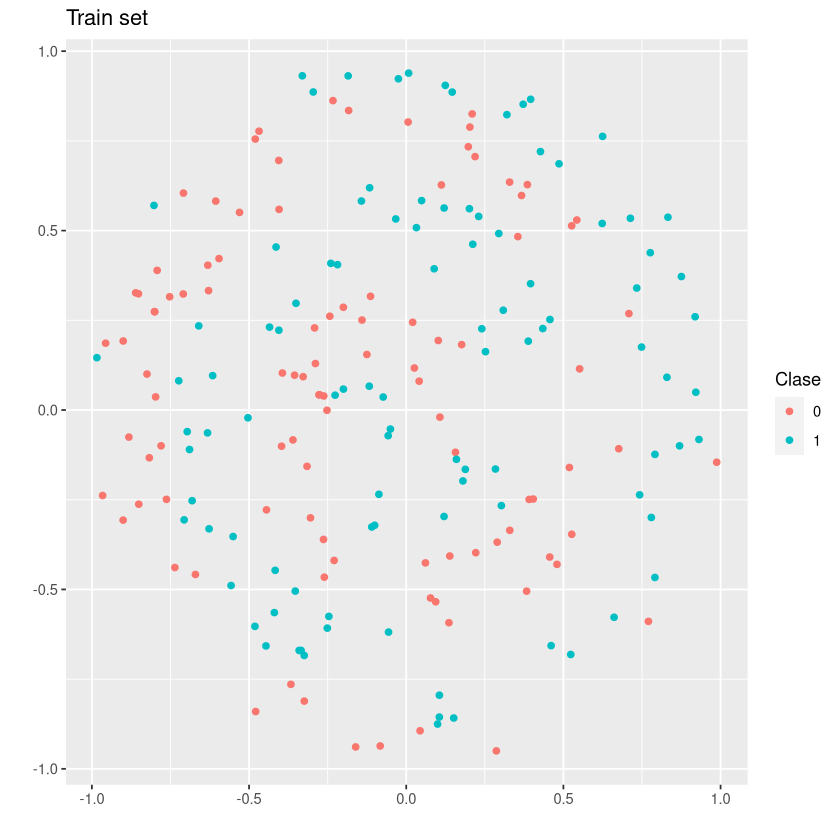

   predictTreeSpirals
      0   1
  0 146 854
  1  11 989

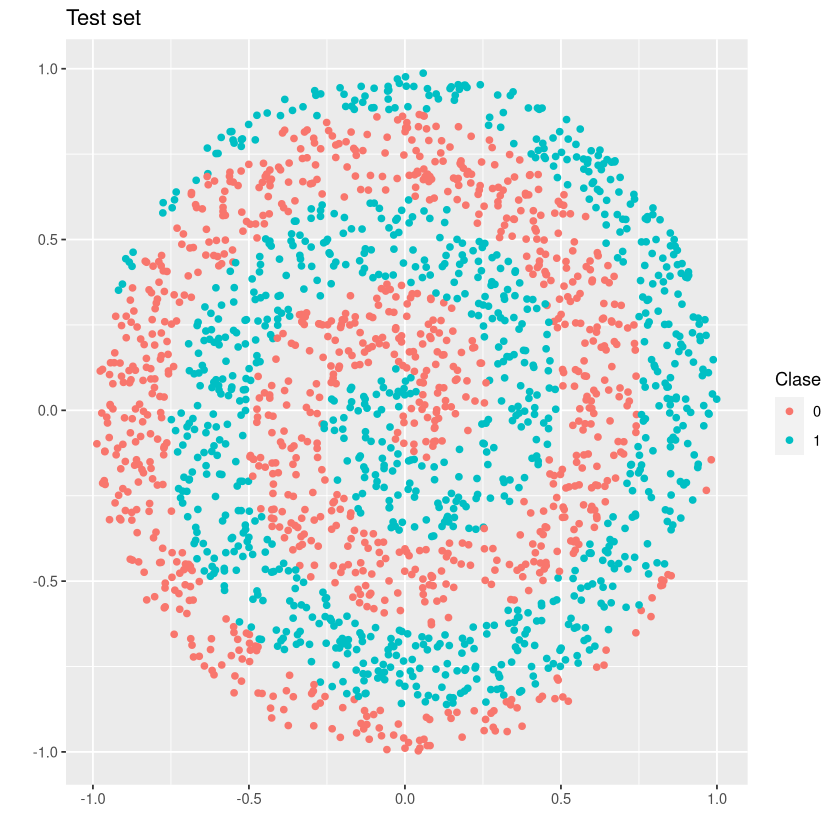

   predictKNNSpirals
       0    1
  0 1000    0
  1    0 1000

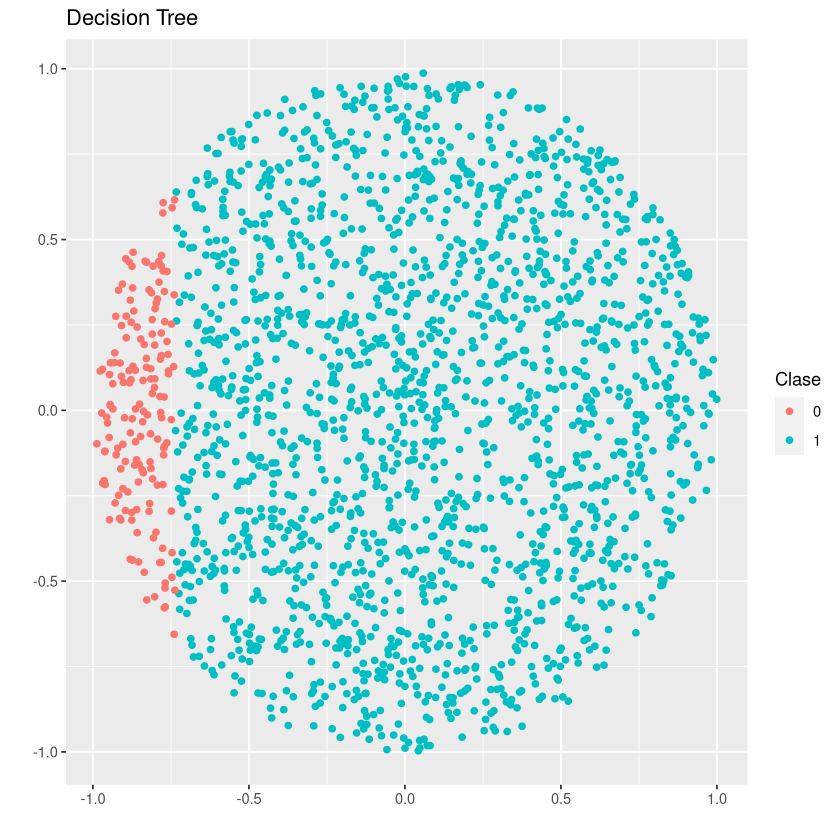

Errores finales 
Sin folds
Error de árbol:  0.4325 
Error de KNN:  0 
Con folds
Error de árbol:  0.445 
Error de KNN:  0 


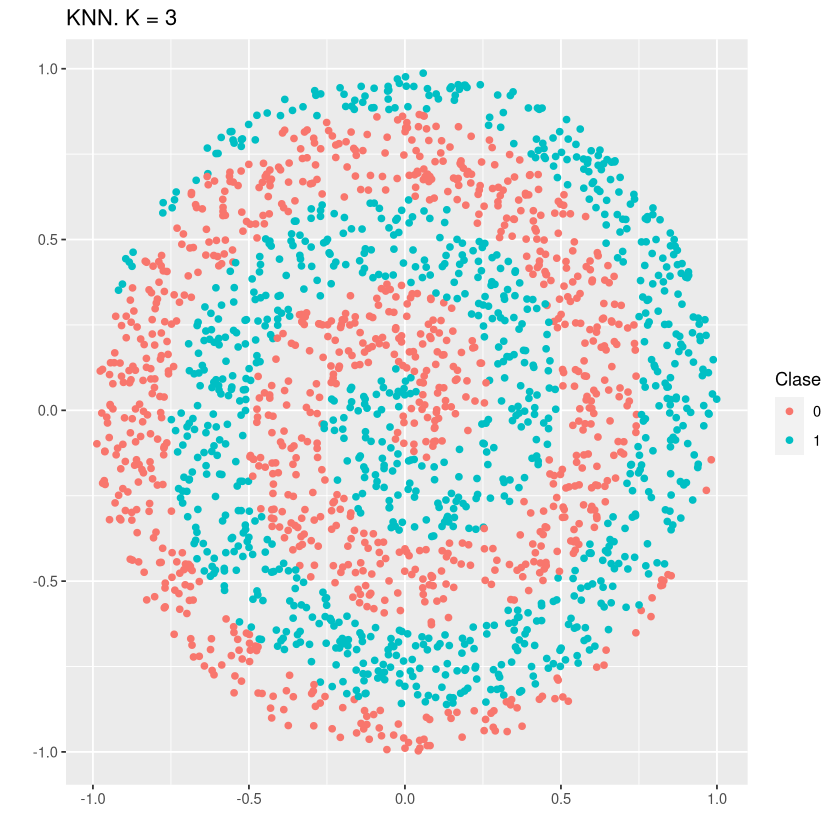

In [35]:
# Genero los conjuntos de entrenamiento y test
dfTrainSpirals = generateSpirals(200)
dfTestSpirals = generateSpirals(2000)

# Los grafico
graphDF(dfTrainSpirals, title = "Train set")
graphDF(dfTestSpirals, title = "Test set")

# Creo un árbol de decisión y predigo
treeSpirals <- ctree(Class ~ ., dfTrainSpirals)
predictTreeSpirals <- predict(treeSpirals, dfTestSpirals)
# Matriz de confusión
table(dfTestSpirals$Class, predictTreeSpirals)
errorTreeSpirals <- calcularError(dfTestSpirals, predictTreeSpirals)

# Grafico la predicción
dfTreePredict <- dfTestSpirals
dfTreePredict["Class"] <- predictTreeSpirals
graphDF(dfTreePredict, title = "Decision Tree")


# Predigo con k-vecinos, k = 3
predictKNNSpirals <- knn(train = dfTrainSpirals, test = dfTestSpirals, 
                          cl = dfTrainSpirals$Class, k = 3)
table(dfTestSpirals$Class, predictKNNSpirals)
errorKNNSpirals <- calcularError(dfTestSpirals, predictKNNSpirals)

# Grafico la predicción
dfKNNPredict <- dfTestSpirals
dfKNNPredict["Class"] <- predictKNNSpirals
graphDF(dfKNNPredict, title = "KNN. K = 3")

# Creo los folds
indexData <- createFolds(t(dfTrainSpirals[, "Class"]), k = 5)

errorsTree <- c()
errorsKNN <- c()

# Robado de IIA
for (kFold in 1:5) {
  foldTrain <- dfTrainSpirals[setdiff(seq(1:dim(dfTrainSpirals)[1]), indexData[[kFold]]), ]
  foldTest <- dfTrainSpirals[indexData[[kFold]], ]

  treeSpirals <- ctree(Class ~ ., foldTrain)
  predictTreeSpirals <- predict(treeSpirals, foldTest)
  errorsTree <- c(calcularError(foldTest, predictTreeSpirals), errorsTree)

  predictKNNSpirals <- knn(train = foldTrain, test = foldTest, 
                          cl = foldTrain$Class, k = 3)
  errorsKNN <- c(calcularError(foldTest, predictKNNSpirals), errorsKNN)
}

cat("Errores finales \nSin folds\n")
cat("Error de árbol: ", errorTreeSpirals, "\n")
cat("Error de KNN: ", errorKNNSpirals, "\n")
cat("Con folds\n")
cat("Error de árbol: ", sum(errorsTree) / 5, "\n")
cat("Error de KNN: ", sum(errorsKNN) / 5, "\n")

Los resultados son iguales a los obtenidos en machine learning.

El problema de las espirales es que no se puede resolver utilizando cortes lineales
paralelos a los ejes, por lo que un árbol de decisión es totalmente inútil para este
problema específico.

Sobre KNN, igual a ML, clasifica perfectamente ya que los datos no tienen ruido,
las curvas que separan las clases están definidas claramente y no se cruzan puntos,
por lo que para un punto los vecinos más cercanos suelen ser de su misma clase.

Utilizar 5-folds en este problema no tiene efecto en los resultados obtenidos,
puedo suponer porque es más un problema sobre los modelos utilizados y no sobre
los datos en sí.
